In [1]:
import torch, torchaudio, torchvision.transforms as transforms, matplotlib.pyplot as plt, torch.nn as nn, torch.optim as optim, numpy as np
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score
from torch.autograd import grad

print(torch.cuda.device_count())
cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")
data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]


2
NVIDIA A30
(872, 4500, 14) (872,)


# Conditional GAN

In [2]:
# Enhanced Conv1D Generator for Time Series
class Conv1DConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=2, num_features=14, seq_len=4500):
        super(Conv1DConditionalGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.num_features = num_features
        self.seq_len = seq_len
        
        # Label embedding
        self.label_emb = nn.Embedding(num_classes, 50)
        
        # Initial size after first linear layer
        self.init_size = seq_len // 64  # Will be upsampled
        input_dim = latent_dim + 50  # latent + label embedding
        
        # Initial projection
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256 * self.init_size),
            nn.BatchNorm1d(256 * self.init_size),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Conv1D upsampling blocks
        self.conv_blocks = nn.Sequential(
            # Block 1: 256 -> 128 channels
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 2: 128 -> 64 channels  
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 3: 64 -> 32 channels
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 4: 32 -> 16 channels
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 5: 16 -> 8 channels
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Final block: 8 -> num_features channels
            nn.ConvTranspose1d(8, num_features, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in [-1, 1] range
        )
        
    def forward(self, z, labels):
        # Embed labels
        label_emb = self.label_emb(labels)  # (batch_size, 50)
        
        # Concatenate noise and label embedding
        gen_input = torch.cat((z, label_emb), dim=1)  # (batch_size, latent_dim + 50)
        
        # Project to initial size
        out = self.fc(gen_input)  # (batch_size, 256 * init_size)
        out = out.view(out.shape[0], 256, self.init_size)  # (batch_size, 256, init_size)
        
        # Apply conv blocks
        out = self.conv_blocks(out)  # (batch_size, num_features, length)
        
        # Ensure correct sequence length
        if out.shape[2] != self.seq_len:
            out = nn.functional.interpolate(out, size=self.seq_len, mode='linear', align_corners=False)
        
        # Transpose to (batch_size, seq_len, num_features)
        return out.transpose(1, 2)

# Enhanced Conv1D Discriminator for Time Series
class Conv1DConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=2, num_features=14, seq_len=4500):
        super(Conv1DConditionalDiscriminator, self).__init__()
        self.num_classes = num_classes
        self.num_features = num_features
        self.seq_len = seq_len
        
        # Label embedding and projection
        self.label_emb = nn.Embedding(num_classes, 50)
        self.label_proj = nn.Linear(50, seq_len)
        
        # Conv1D blocks for feature extraction
        self.conv_blocks = nn.Sequential(
            # Input: (num_features + 1) channels, seq_len length
            nn.Conv1d(num_features + 1, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Calculate the size after convolutions
        self.conv_output_size = self._get_conv_output_size()
        
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * self.conv_output_size, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        
    def _get_conv_output_size(self):
        size = self.seq_len
        for _ in range(6):  # 6 conv layers
            size = (size - 4 + 2) // 2 + 1
        return size
    
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        # Embed and project labels to match sequence length
        label_emb = self.label_emb(labels)  # (batch_size, 50)
        label_seq = self.label_proj(label_emb)  # (batch_size, seq_len)
        label_seq = label_seq.unsqueeze(1)  # (batch_size, 1, seq_len)
        
        # Transpose x to (batch_size, num_features, seq_len)
        x = x.transpose(1, 2)
        
        # Concatenate data and label along feature dimension
        x_labeled = torch.cat([x, label_seq], dim=1)  # (batch_size, num_features + 1, seq_len)
        
        # Apply conv blocks
        features = self.conv_blocks(x_labeled)  # (batch_size, 512, conv_output_size)
        
        # Flatten and classify
        features_flat = features.view(batch_size, -1)
        output = self.classifier(features_flat)
        
        return output

# Enhanced training function
def train_conditional_gan_conv1d(normal_data, normal_labels, device, epochs=50, batch_size=64, lr_g=0.0002, lr_d=0.0001):
    """
    Train Conditional GAN with Conv1D layers for time series data
    """
    print(f"Training data shape: {normal_data.shape}")
    print(f"Labels shape: {normal_labels.shape}")
    
    # Data preprocessing
    data_min = normal_data.min()
    data_max = normal_data.max()
    normalized_data = 2 * (normal_data - data_min) / (data_max - data_min) - 1
    print(f"Normalized data range: [{normalized_data.min():.4f}, {normalized_data.max():.4f}]")
    
    # Model parameters
    latent_dim = 100
    num_classes = len(np.unique(normal_labels))
    num_features = normalized_data.shape[-1]
    seq_len = normalized_data.shape[1]
    
    print(f"Model parameters: latent_dim={latent_dim}, num_classes={num_classes}, num_features={num_features}, seq_len={seq_len}")
    
    # Initialize models
    generator = Conv1DConditionalGenerator(latent_dim, num_classes, num_features, seq_len).to(device)
    discriminator = Conv1DConditionalDiscriminator(num_classes, num_features, seq_len).to(device)
    
    # Weight initialization
    def weights_init(m):
        if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.BatchNorm1d)):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)
    
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    
    # Optimizers with balanced learning rates
    optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    
    # Loss function
    criterion = nn.BCEWithLogitsLoss()
    
    # Create dataloader
    dataset = TensorDataset(
        torch.tensor(normalized_data, dtype=torch.float32),
        torch.tensor(normal_labels, dtype=torch.long)
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    print("Starting Conv1D Conditional GAN training...")
    print(f"Learning rates - Generator: {lr_g}, Discriminator: {lr_d}")
    
    # Training history
    d_losses = []
    g_losses = []
    
    for epoch in range(epochs):
        epoch_d_losses = []
        epoch_g_losses = []
        
        for i, (real_data, real_labels) in enumerate(dataloader):
            real_data = real_data.to(device)
            real_labels = real_labels.to(device)
            current_batch_size = real_data.size(0)
            
            # Create labels for real and fake
            valid = torch.ones(current_batch_size, 1, device=device)
            fake = torch.zeros(current_batch_size, 1, device=device)
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            
            # Real data loss
            real_pred = discriminator(real_data, real_labels)
            d_real_loss = criterion(real_pred, valid)
            
            # Fake data loss
            z = torch.randn(current_batch_size, latent_dim, device=device)
            gen_labels = torch.randint(0, num_classes, (current_batch_size,), device=device)
            fake_data = generator(z, gen_labels)
            fake_pred = discriminator(fake_data.detach(), gen_labels)
            d_fake_loss = criterion(fake_pred, fake)
            
            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
            
            optimizer_D.step()
            epoch_d_losses.append(d_loss.item())
            
            # ---------------------
            #  Train Generator
            # ---------------------
            if i % 2 == 0:  # Train generator less frequently
                optimizer_G.zero_grad()
                
                # Generate fake data
                z = torch.randn(current_batch_size, latent_dim, device=device)
                gen_labels = torch.randint(0, num_classes, (current_batch_size,), device=device)
                fake_data = generator(z, gen_labels)
                
                # Generator loss (want discriminator to classify fake as real)
                fake_pred = discriminator(fake_data, gen_labels)
                g_loss = criterion(fake_pred, valid)
                
                g_loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
                
                optimizer_G.step()
                epoch_g_losses.append(g_loss.item())
        
        # Calculate average losses
        avg_d_loss = np.mean(epoch_d_losses)
        avg_g_loss = np.mean(epoch_g_losses) if epoch_g_losses else 0
        
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        
        # Print progress every 5 epochs
        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs} | D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")
            
            # Monitor training stability
            if len(d_losses) >= 10:
                recent_d_std = np.std(d_losses[-10:])
                recent_g_std = np.std(g_losses[-10:]) if len(g_losses) >= 10 else 0
                
                if recent_d_std < 0.1 and recent_g_std < 0.1:
                    print("  ✅ Training highly stable")
                elif recent_d_std < 0.2 and recent_g_std < 0.2:
                    print("  🔄 Training moderately stable")
                else:
                    print("  ⚠️  Training showing some instability")
    
    return generator, discriminator, d_losses, g_losses, (data_min, data_max)

# Enhanced sample generation
def generate_conditional_samples(generator, num_samples, target_class, seq_len, latent_dim, device, data_range):
    """
    Generate conditional samples for a specific class
    """
    generator.eval()
    data_min, data_max = data_range
    
    generated_batches = []
    batch_size = 32
    
    with torch.no_grad():
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            current_batch_size = end - start
            
            z = torch.randn(current_batch_size, latent_dim, device=device)
            labels = torch.full((current_batch_size,), target_class, dtype=torch.long, device=device)
            
            batch_generated = generator(z, labels)
            
            # Denormalize from [-1, 1] back to original range
            batch_generated = (batch_generated + 1) / 2 * (data_max - data_min) + data_min
            
            generated_batches.append(batch_generated.cpu())
    
    return torch.cat(generated_batches, dim=0).numpy()

# Conditional GAN Training

Training data shape: (690, 4500, 14)
Labels shape: (690,)
Normalized data range: [-1.0000, 1.0000]
Model parameters: latent_dim=100, num_classes=1, num_features=14, seq_len=4500
Starting Conv1D Conditional GAN training...
Learning rates - Generator: 0.02, Discriminator: 0.0001
Epoch 1/60 | D Loss: 0.2775 | G Loss: 3.4634
Epoch 6/60 | D Loss: 0.0012 | G Loss: 11.9487
Epoch 11/60 | D Loss: 1.2661 | G Loss: 1.8928
  ⚠️  Training showing some instability
Epoch 16/60 | D Loss: 0.7249 | G Loss: 0.9114
  ⚠️  Training showing some instability
Epoch 21/60 | D Loss: 0.7291 | G Loss: 1.0827
  🔄 Training moderately stable
Epoch 26/60 | D Loss: 0.6967 | G Loss: 0.8757
  ✅ Training highly stable
Epoch 31/60 | D Loss: 0.6866 | G Loss: 0.9943
  ✅ Training highly stable
Epoch 36/60 | D Loss: 0.6824 | G Loss: 0.8877
  ✅ Training highly stable
Epoch 41/60 | D Loss: 0.6800 | G Loss: 0.8690
  ✅ Training highly stable
Epoch 46/60 | D Loss: 0.7130 | G Loss: 0.8626
  ✅ Training highly stable
Epoch 51/60 | D L

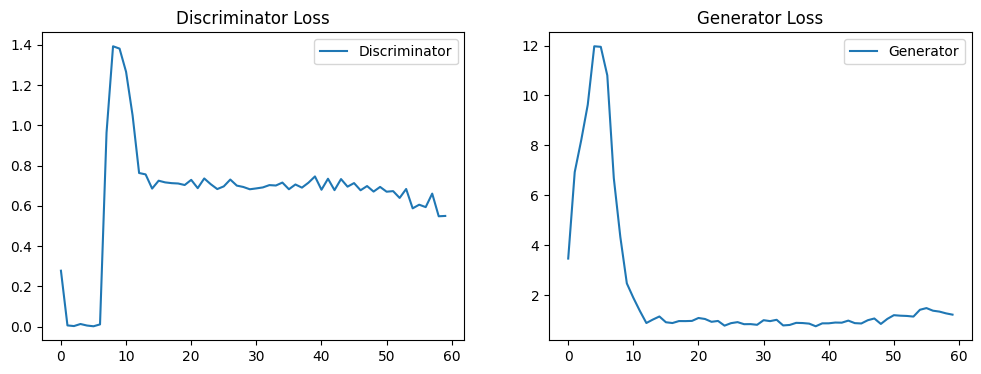

In [8]:
# Enhanced training with balanced learning rates
generator, discriminator, d_history, g_history, data_range = train_conditional_gan_conv1d(
    normal_data, 
    normal_label,
    device, 
    epochs=60,
    batch_size=32,
    lr_g=0.02,        # Balanced learning rate
    lr_d=0.0001         # 2:1 ratio
)

# Generate samples for class 0 (normal)
generated_data = generate_conditional_samples(
    generator, 
    num_samples=len(normal_data), 
    target_class=0, 
    seq_len=normal_data.shape[1], 
    latent_dim=100, 
    device=device, 
    data_range=data_range
)

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(d_history, label='Discriminator')
plt.title('Discriminator Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(g_history, label='Generator')
plt.title('Generator Loss')
plt.legend()
plt.show()

# Generate and Combine

In [10]:

# Combine with real data
combine_data_normal = np.concatenate((generated_data, normal_data), axis=0)
combine_labels_normal = np.concatenate((np.zeros(len(generated_data)), normal_label), axis=0)


# Processing: Mel Spec > Resizing > Feature Extraction

In [11]:
def resize_spectrogram(spectrogram, global_min=None, global_max=None):
    """
    Improved spectrogram processing with consistent normalization
    """
    # Use global min/max for consistent normalization across all spectrograms
    if global_min is not None and global_max is not None:
        spectrogram = (spectrogram - global_min) / (global_max - global_min + 1e-8)
    else:
        spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-8)
    
    # Clip to [0,1] and convert to uint8
    spectrogram = np.clip(spectrogram, 0, 1)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

def process_dataset_improved(data, sample_rate=1000):  # More reasonable sample rate
    """
    Improved dataset processing with better mel-spectrogram parameters
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    
    # Better mel-spectrogram parameters for sensor data
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,          # Reasonable FFT size
        hop_length=256,     # 50% overlap
        win_length=512,
        window_fn=torch.hann_window
    ).to(device)
    
    # Load VGG16 model
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    # Compute global min/max for consistent normalization
    print("Computing global spectrogram statistics...")
    all_mels = []
    for i in range(min(100, num_samples)):  # Sample subset for statistics
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            all_mels.append(mel.cpu().numpy())
    
    all_mels = np.concatenate([mel.flatten() for mel in all_mels])
    global_min, global_max = np.percentile(all_mels, [1, 99])  # Use percentiles to avoid outliers
    
    print(f"Processing {num_samples} samples...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
            
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Use consistent normalization
            img = resize_spectrogram(mel, global_min, global_max)
            
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    
    return features

# Alternative: Multi-channel processing
def process_dataset_multichannel(data, sample_rate=1000):
    """
    Process multiple channels together to capture cross-channel relationships
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, 4096))  # Single feature vector per sample
    
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,
        hop_length=256,
        win_length=512
    ).to(device)
    
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    print(f"Processing {num_samples} samples with multi-channel approach...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
        
        # Combine multiple channels into RGB image
        channel_spectrograms = []
        for j in range(min(3, num_channels)):  # Use first 3 channels as RGB
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Normalize each channel spectrogram
            mel_norm = (mel - mel.min()) / (mel.max() - mel.min() + 1e-8)
            mel_resized = torch.nn.functional.interpolate(
                mel_norm.unsqueeze(0).unsqueeze(0), 
                size=(224, 224), 
                mode='bilinear'
            ).squeeze()
            channel_spectrograms.append(mel_resized.cpu().numpy())
        
        # Stack as RGB image
        if len(channel_spectrograms) == 1:
            rgb_img = np.stack([channel_spectrograms[0]] * 3, axis=0)
        elif len(channel_spectrograms) == 2:
            rgb_img = np.stack([channel_spectrograms[0], channel_spectrograms[1], channel_spectrograms[0]], axis=0)
        else:
            rgb_img = np.stack(channel_spectrograms[:3], axis=0)
        
        img_tensor = torch.tensor(rgb_img, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            feat = model(img_tensor)
        features[i, :] = feat.squeeze().cpu().numpy()
    
    return features

# AE Class

In [12]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.Tanh(),
            nn.Linear(64, 32), 
            nn.Tanh(),
            nn.Linear(32, 16), 
            nn.Tanh(),
            nn.Linear(16, 8), 
            nn.Tanh(),
            nn.Linear(8, 4), 
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.Tanh(),
            nn.Linear(8, 16), 
            nn.Tanh(),
            nn.Linear(16, 32), 
            nn.Tanh(),
            nn.Linear(32, 64), 
            nn.Tanh(),
            nn.Linear(64, input_size), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=128):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Add weight decay
    criterion = nn.MSELoss()  # Try MSE instead of L1

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            # Add noise for denoising autoencoder
            noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
            outputs = model(noisy_inputs)
            loss = criterion(outputs, inputs)  # Reconstruct clean from noisy
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model

# Compute reconstruction errors
def compute_reconstruction_loss(model, data, add_noise=True):
    """
    Compute reconstruction loss per sample (not per segment)
    data: shape (n_samples, n_channels, 4096)
    """
    model.eval()
    n_samples, n_channels, n_features = data.shape
    sample_errors = []
    
    # Flatten to (n_samples*n_channels, 4096) for batch processing
    x = torch.tensor(data.reshape(-1, n_features), dtype=torch.float32).to(next(model.parameters()).device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    
    all_errors = []
    criterion = torch.nn.MSELoss(reduction='none')
    
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            
            if add_noise:
                noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
                outputs = model(noisy_inputs)
            else:
                outputs = model(inputs)
            
            # Per-segment reconstruction error
            segment_errors = criterion(outputs, inputs).mean(dim=1)
            all_errors.extend(segment_errors.cpu().numpy())
    
    # Reshape back to (n_samples, n_channels) and aggregate per sample
    all_errors = np.array(all_errors).reshape(n_samples, n_channels)
    sample_errors = all_errors.mean(axis=1)  # Average across channels per sample
    
    return sample_errors

# 2. Find best threshold based on F1 score
def find_best_threshold(errors, labels):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(min(errors), max(errors), 100):
        preds = (errors > threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

def evaluate_on_test_with_threshold_search(model, X_test, y_test):
    """
    X_test: shape (n_samples, 1, 4096) - already has channel dimension added
    y_test: shape (n_samples,)
    """
    # X_test already has shape (n_samples, 1, 4096) from your code
    # So we can directly compute reconstruction errors
    test_errors = compute_reconstruction_loss(model, X_test)
    
    # Find best threshold based on F1 score
    best_threshold = 0
    best_f1 = 0
    for threshold in np.linspace(test_errors.min(), test_errors.max(), 100):
        preds = (test_errors > threshold).astype(int)
        f1 = f1_score(y_test, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Predict using best threshold
    test_preds = (test_errors > best_threshold).astype(int)

    # Evaluate
    print(f"Best Threshold = {best_threshold:.6f}, Best F1 Score = {best_f1:.4f}")
    print("Evaluation on Test Set:")
    print("Accuracy =", accuracy_score(y_test, test_preds))
    print("Precision =", precision_score(y_test, test_preds))
    print("Recall =", recall_score(y_test, test_preds))
    print("F1 Score =", f1_score(y_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))


# Preprocessing

In [13]:
combine_data = np.concatenate((combine_data_normal, data[label == 1]), axis=0)  # Combine real and generated data
combine_label = np.concatenate((np.zeros(len(combine_labels_normal)), label[label == 1]), axis=0)  # Labels: 0 for real, 0 for generated

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaled_normal_data = StandardScaler().fit_transform(combine_data_normal.reshape(-1, combine_data_normal.shape[-1])).reshape(combine_data_normal.shape)
scaled_original_data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
features_original = process_dataset_multichannel(scaled_original_data)
print("Features shape:", features_original.shape)
features_normal = process_dataset_multichannel(scaled_normal_data)
print("Features shape:", features_normal.shape)

Processing 872 samples with multi-channel approach...
Processed 0/872 samples
Processed 100/872 samples
Processed 200/872 samples
Processed 300/872 samples
Processed 400/872 samples
Processed 500/872 samples
Processed 600/872 samples
Processed 700/872 samples
Processed 800/872 samples
Features shape: (872, 4096)
Processing 1380 samples with multi-channel approach...
Processed 0/1380 samples
Processed 100/1380 samples
Processed 200/1380 samples
Processed 300/1380 samples
Processed 400/1380 samples
Processed 500/1380 samples
Processed 600/1380 samples
Processed 700/1380 samples
Processed 800/1380 samples
Processed 900/1380 samples
Processed 1000/1380 samples
Processed 1100/1380 samples
Processed 1200/1380 samples
Processed 1300/1380 samples
Features shape: (1380, 4096)


# Cross Validation with StandardScaler

Fold 1
Epoch 1/15, Loss: 1.186550
Epoch 2/15, Loss: 0.831917
Epoch 3/15, Loss: 0.597649
Epoch 4/15, Loss: 0.565094
Epoch 5/15, Loss: 0.560706
Epoch 6/15, Loss: 0.559095
Epoch 7/15, Loss: 0.558360
Epoch 8/15, Loss: 0.558034
Epoch 9/15, Loss: 0.557723
Epoch 10/15, Loss: 0.557397
Epoch 11/15, Loss: 0.557048
Epoch 12/15, Loss: 0.556957
Epoch 13/15, Loss: 0.556686
Epoch 14/15, Loss: 0.556464
Epoch 15/15, Loss: 0.556105
Best threshold: 0.511776330796155, Best F1 Score: 0.5306122448979592


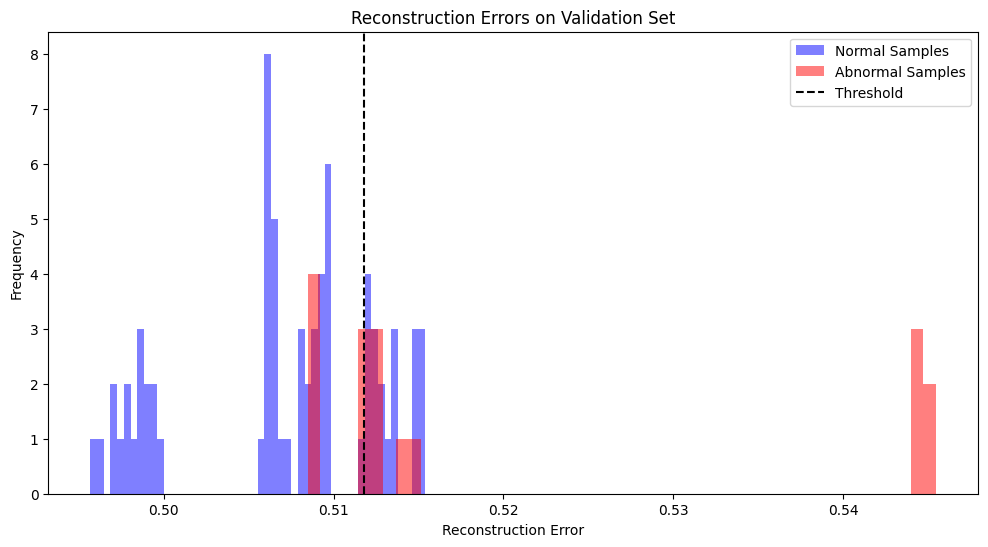

Best Threshold = 0.513836, Best F1 Score = 0.6250
Evaluation on Test Set:
Accuracy = 0.8636363636363636
Precision = 0.8333333333333334
Recall = 0.5
F1 Score = 0.625
Confusion Matrix:
 [[66  2]
 [10 10]]
Fold 2
Epoch 1/15, Loss: 1.200659
Epoch 2/15, Loss: 0.885554
Epoch 3/15, Loss: 0.606437
Epoch 4/15, Loss: 0.563641
Epoch 5/15, Loss: 0.559562
Epoch 6/15, Loss: 0.558798
Epoch 7/15, Loss: 0.558352
Epoch 8/15, Loss: 0.557865
Epoch 9/15, Loss: 0.557408
Epoch 10/15, Loss: 0.557114
Epoch 11/15, Loss: 0.557090
Epoch 12/15, Loss: 0.556239
Epoch 13/15, Loss: 0.556321
Epoch 14/15, Loss: 0.556369
Epoch 15/15, Loss: 0.555984
Best threshold: 0.5120276591994546, Best F1 Score: 0.6530612244897959


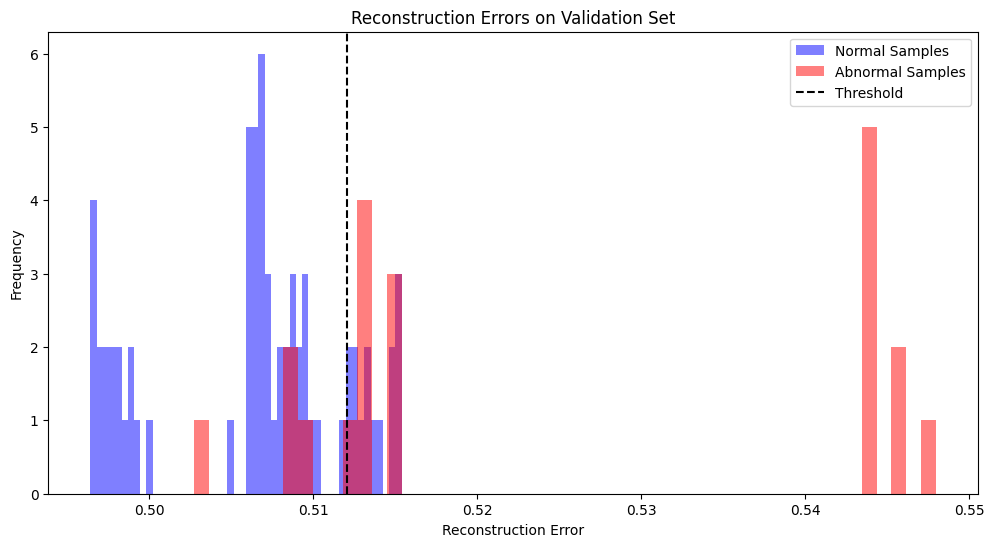

Best Threshold = 0.514766, Best F1 Score = 0.7333
Evaluation on Test Set:
Accuracy = 0.9090909090909091
Precision = 0.8461538461538461
Recall = 0.6470588235294118
F1 Score = 0.7333333333333334
Confusion Matrix:
 [[69  2]
 [ 6 11]]
Fold 3
Epoch 1/15, Loss: 1.186959
Epoch 2/15, Loss: 0.838276
Epoch 3/15, Loss: 0.596137
Epoch 4/15, Loss: 0.564672
Epoch 5/15, Loss: 0.560472
Epoch 6/15, Loss: 0.559752
Epoch 7/15, Loss: 0.559054
Epoch 8/15, Loss: 0.558224
Epoch 9/15, Loss: 0.557827
Epoch 10/15, Loss: 0.557595
Epoch 11/15, Loss: 0.556751
Epoch 12/15, Loss: 0.556820
Epoch 13/15, Loss: 0.556539
Epoch 14/15, Loss: 0.556513
Epoch 15/15, Loss: 0.556113
Best threshold: 0.5130409026386762, Best F1 Score: 0.5714285714285713


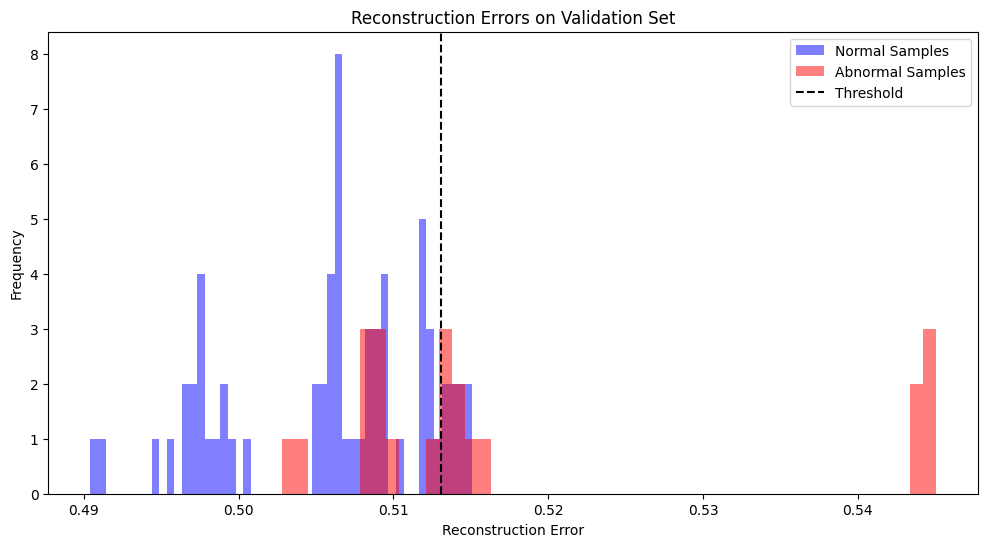

Best Threshold = 0.514722, Best F1 Score = 0.6400
Evaluation on Test Set:
Accuracy = 0.896551724137931
Precision = 0.7272727272727273
Recall = 0.5714285714285714
F1 Score = 0.64
Confusion Matrix:
 [[70  3]
 [ 6  8]]
Fold 4
Epoch 1/15, Loss: 1.200959
Epoch 2/15, Loss: 0.869245
Epoch 3/15, Loss: 0.602529
Epoch 4/15, Loss: 0.563830
Epoch 5/15, Loss: 0.560088
Epoch 6/15, Loss: 0.558934
Epoch 7/15, Loss: 0.558158
Epoch 8/15, Loss: 0.557783
Epoch 9/15, Loss: 0.557488
Epoch 10/15, Loss: 0.557349
Epoch 11/15, Loss: 0.556881
Epoch 12/15, Loss: 0.556849
Epoch 13/15, Loss: 0.556318
Epoch 14/15, Loss: 0.556666
Epoch 15/15, Loss: 0.556435
Best threshold: 0.5120639548157201, Best F1 Score: 0.7906976744186046


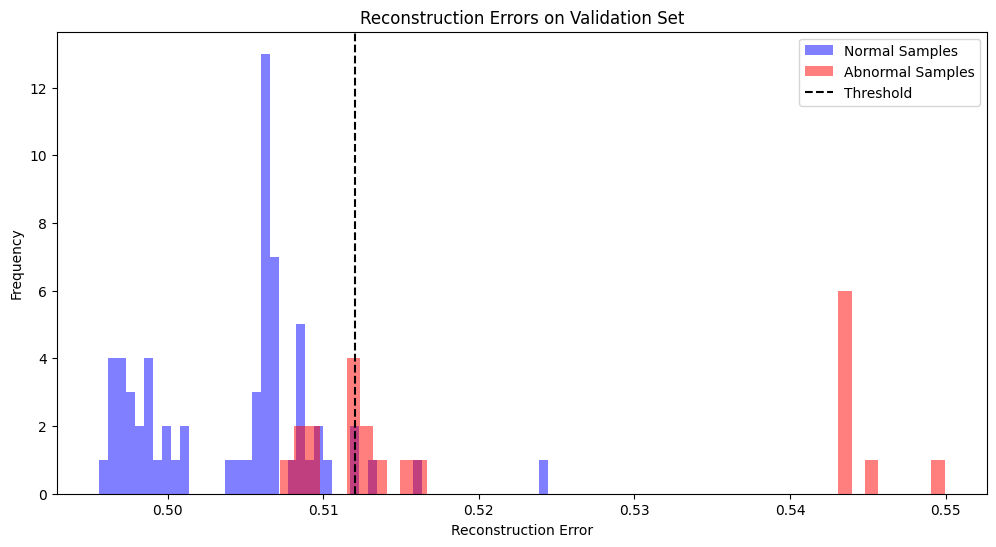

Best Threshold = 0.513358, Best F1 Score = 0.5714
Evaluation on Test Set:
Accuracy = 0.8620689655172413
Precision = 0.5714285714285714
Recall = 0.5714285714285714
F1 Score = 0.5714285714285714
Confusion Matrix:
 [[67  6]
 [ 6  8]]
Fold 5
Epoch 1/15, Loss: 1.192096
Epoch 2/15, Loss: 0.836710
Epoch 3/15, Loss: 0.596793
Epoch 4/15, Loss: 0.565033
Epoch 5/15, Loss: 0.560750
Epoch 6/15, Loss: 0.559576
Epoch 7/15, Loss: 0.558597
Epoch 8/15, Loss: 0.558353
Epoch 9/15, Loss: 0.557861
Epoch 10/15, Loss: 0.557621
Epoch 11/15, Loss: 0.557448
Epoch 12/15, Loss: 0.556529
Epoch 13/15, Loss: 0.556699
Epoch 14/15, Loss: 0.556603
Epoch 15/15, Loss: 0.556487
Best threshold: 0.5127545083412016, Best F1 Score: 0.717948717948718


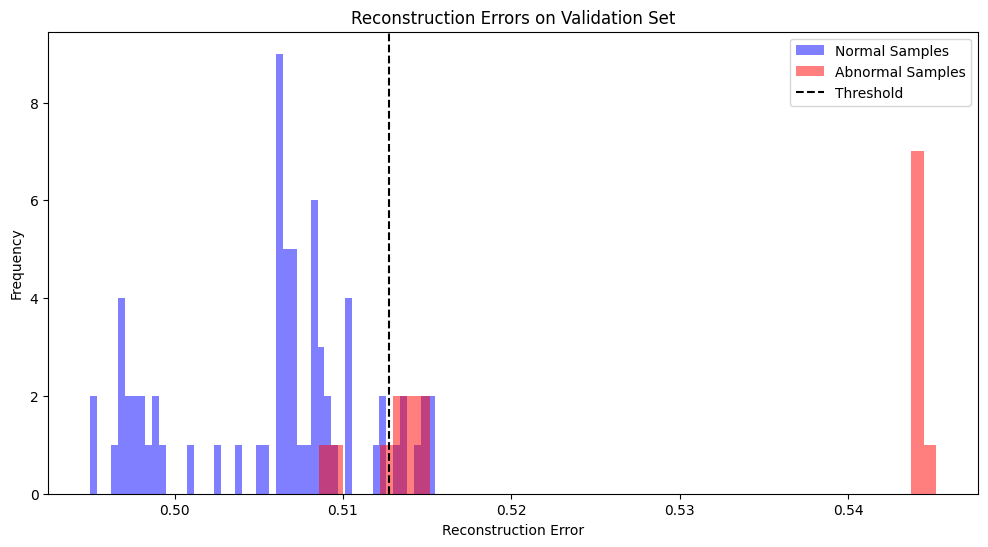

Best Threshold = 0.515970, Best F1 Score = 0.6897
Evaluation on Test Set:
Accuracy = 0.896551724137931
Precision = 1.0
Recall = 0.5263157894736842
F1 Score = 0.6896551724137931
Confusion Matrix:
 [[68  0]
 [ 9 10]]


In [14]:
acc = []
prec = []
rec = []
f1 = []
for fold, (train_idx, val_idx) in enumerate(skf.split(features_original, label)):
    
    print(f"Fold {fold + 1}")
    
   # Get full fold data
    fold_data, fold_labels = features_original[train_idx], label[train_idx]
    val_data, val_labels = features_original[val_idx], label[val_idx]
   
    # Split into training and validation folds
    X_train, X_temp, y_train, y_temp = train_test_split(fold_data, fold_labels, test_size=0.2, shuffle=True, random_state=np.random.randint(0, 1000))
    X_val, X_test, y_val, y_test = train_test_split(val_data, val_labels, test_size=0.5, shuffle=True, random_state=np.random.randint(0, 1000))


    # Train autoencoder on the training fold
    model = train_autoencoder(features_normal, epochs=15, batch_size=64)

    # Add channel dimension to X_val
    X_val = X_val[:, np.newaxis, :]

    # Evaluate on validation fold
    val_normal = X_val[y_val == 0]
    val_abnormal = X_val[y_val == 1]
    val_errors_normal = compute_reconstruction_loss(model, val_normal)
    val_errors_abnormal = compute_reconstruction_loss(model, val_abnormal)
    val_errors = np.concatenate([val_errors_normal, val_errors_abnormal])
    y_val_combined = np.concatenate([np.zeros(len(val_errors_normal)), np.ones(len(val_errors_abnormal))])
    
    threshold, best_f1 = find_best_threshold(val_errors, y_val_combined)
    print(f"Best threshold: {threshold}, Best F1 Score: {best_f1}")

    # Plot histogram of reconstruction errors on both normal and abnormal samples
    plt.figure(figsize=(12, 6))
    plt.hist(val_errors_normal, bins=50, alpha=0.5, label='Normal Samples', color='blue')
    plt.hist(val_errors_abnormal, bins=50, alpha=0.5, label='Abnormal Samples', color='red')
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.title('Reconstruction Errors on Validation Set')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    
    X_test = X_test[:, np.newaxis, :]  # Add channel dimension    
    val_errors_test = compute_reconstruction_loss(model, X_test)
    # Evaluate on test set
    evaluate_on_test_with_threshold_search(model, X_test, y_test)
    acc.append(accuracy_score(y_test, (val_errors_test > threshold).astype(int)))
    prec.append(precision_score(y_test, (val_errors_test > threshold).astype(int)))
    rec.append(recall_score(y_test, (val_errors_test > threshold).astype(int)))
    f1.append(f1_score(y_test, (val_errors_test > threshold).astype(int)))



In [15]:
np.mean(acc), np.mean(prec), np.mean(rec), np.mean(f1)

(0.7894723092998954,
 0.4663614163614163,
 0.7097434763379036,
 0.5610148710647049)

# Observation:


Average scores:

Accuracy = 0.7894723092998954

Precision = 0.4663614163614163

Recall = 0.7097434763379036

F1 Score = 0.5610148710647049

Best:

Accuracy = 0.9090909090909091

Precision = 0.8461538461538461

Recall = 0.6470588235294118

F1 Score = 0.7333333333333334

Confusion Matrix:

 [[69  2]

 [ 6 11]]
